In [1]:
import numpy as np
ROLL_NUMBER=102303998
a_r = 0.5 * (ROLL_NUMBER % 7)
b_r = 0.3 * ((ROLL_NUMBER % 5) + 1)

print(f"a_r = {a_r}, b_r = {b_r}")


a_r = 3.0, b_r = 1.2


In [3]:
import pandas as pd

df = pd.read_csv("data.csv",encoding='latin1')

x = df["no2"].dropna().values.astype(np.float32)


/tmp/ipython-input-305217822.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv",encoding='latin1')


In [4]:
z = x + a_r * np.sin(b_r * x)
z = (z - z.mean()) / z.std()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim


In [6]:
class Generator(nn.Module):
    def __init__(self, noise_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.001)
opt_D = optim.Adam(D.parameters(), lr=0.001)

z_tensor = torch.tensor(z).unsqueeze(1).to(device)

epochs = 3000
batch_size = 128


In [9]:
for epoch in range(epochs):
    idx = np.random.randint(0, len(z_tensor), batch_size)
    real = z_tensor[idx]

    noise = torch.randn(batch_size, 1).to(device)
    fake = G(noise)

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D = criterion(D_real, torch.ones_like(D_real)) + \
             criterion(D_fake, torch.zeros_like(D_fake))

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    noise = torch.randn(batch_size, 1).to(device)
    fake = G(noise)
    D_fake = D(fake)

    loss_G = criterion(D_fake, torch.ones_like(D_fake))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.4244 | G Loss: 0.6557
Epoch 500 | D Loss: 1.1640 | G Loss: 0.8609
Epoch 1000 | D Loss: 1.3738 | G Loss: 0.6933
Epoch 1500 | D Loss: 1.3973 | G Loss: 0.6836
Epoch 2000 | D Loss: 1.3066 | G Loss: 0.7575
Epoch 2500 | D Loss: 1.3813 | G Loss: 0.6727


In [10]:
G.eval()
with torch.no_grad():
    noise = torch.randn(10000, 1).to(device)
    z_fake = G(noise).cpu().numpy().flatten()


In [11]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.3)
kde.fit(z_fake.reshape(-1, 1))

z_range = np.linspace(min(z), max(z), 1000)
log_density = kde.score_samples(z_range.reshape(-1, 1))


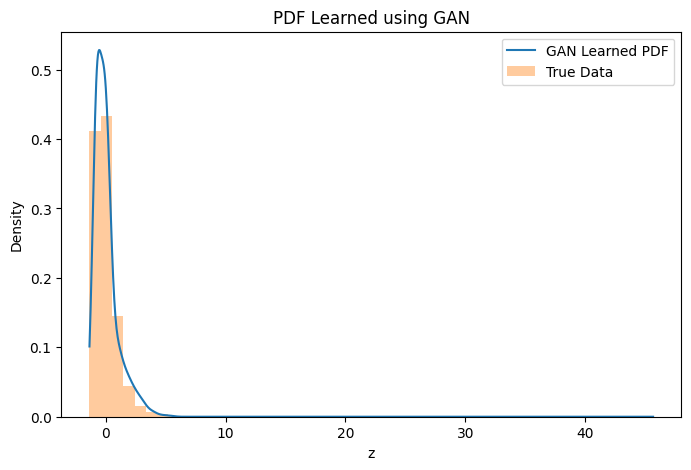

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(z_range, np.exp(log_density), label="GAN Learned PDF")
plt.hist(z, bins=50, density=True, alpha=0.4, label="True Data")
plt.legend()
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Learned using GAN")
plt.show()
